In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# First Exploration of the data

## data information

In [2]:
data = pd.read_csv('data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
# Extract the year from the date
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month

In [3]:
data.head(5)

,STORE,DATE,SKU,QUANTITY_SOLD,CURRENT_LEVEL,YEAR,MONTH
0,mystore,2024-04-03,636723034103246386,1,30,2024,4
1,mystore,2023-06-12,636723034103246386,1,30,2023,6
2,mystore,2023-07-22,636723034103246386,1,30,2023,7
3,mystore,2023-11-17,636723034103246386,2,30,2023,11
4,mystore,2024-02-26,636723034103246386,1,30,2024,2


In [4]:
print(f'length of the data: {data.shape[0]}')
print(f'Number of stores: {data["STORE"].nunique()}')
print(f'Number of SKU:{data["SKU"].nunique()}')
print(f'studied period  of time:{data["DATE"].min()} to {data["DATE"].max()}')
print(f'nulls in data:')
data.isnull().sum()

length of the data: 1026036
Number of stores: 1
Number of SKU:3835
studied period  of time:2015-10-04 00:00:00 to 2024-05-23 00:00:00
nulls in data:


STORE            0
DATE             0
SKU              0
QUANTITY_SOLD    0
CURRENT_LEVEL    0
YEAR             0
MONTH            0
dtype: int64

Data over almost 10 years of the quantity sold for each SKU at a single store

### analysis of the SKU 

count    3835.000000
mean      267.545241
std       420.187724
min         1.000000
10%         5.000000
25%        16.000000
50%        74.000000
75%       344.000000
90%       817.400000
max      2635.000000
Name: SKU, dtype: float64


<AxesSubplot:>

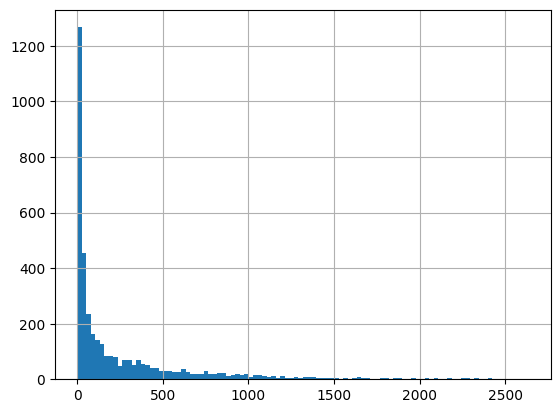

In [5]:
print(data.SKU.value_counts().describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))
data.SKU.value_counts().hist(bins=100)

We see that almost 10% of the data has been sold less than 5 times over the range of 9 years which is too small to deduce an inventory patter
let's try to understand better the evolution of the number of SKUs that has been sold in the store 

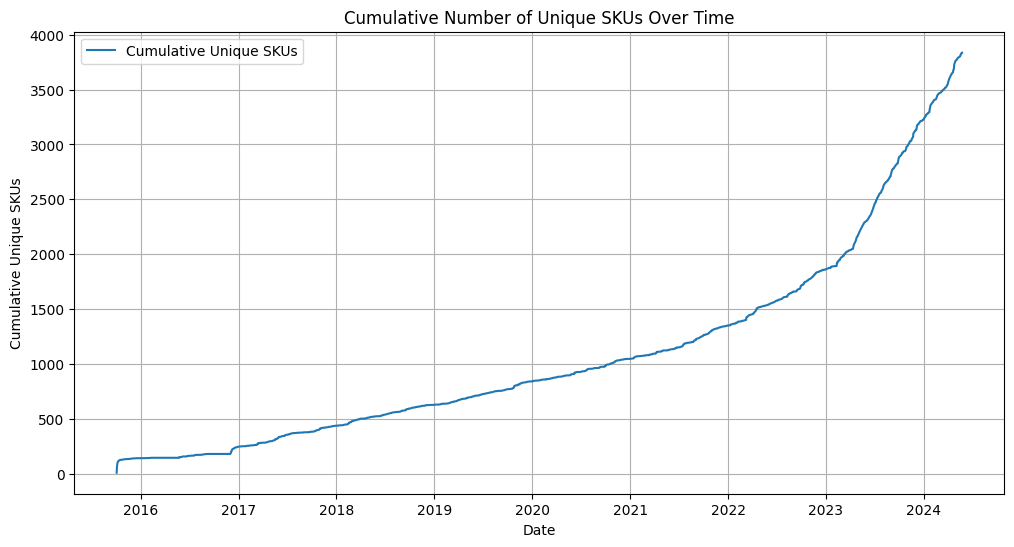

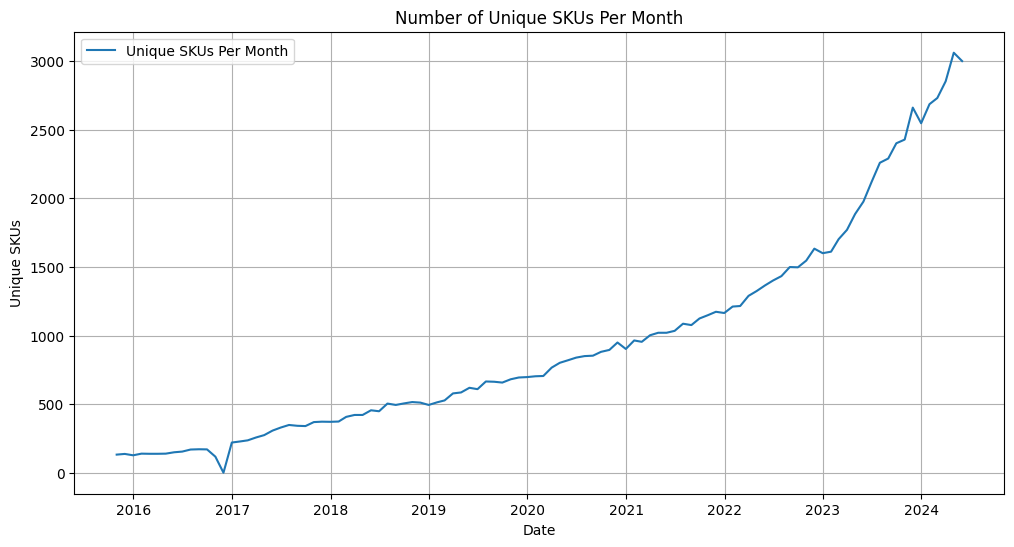

In [14]:
unique_skus_seen = set()

cumulative_unique_skus_count = []

for date, group in data.groupby('DATE'):
    unique_skus_seen.update(group['SKU'])
    cumulative_unique_skus_count.append((date, len(unique_skus_seen)))

cumulative_unique_skus_df = pd.DataFrame(cumulative_unique_skus_count, columns=['DATE', 'CUMULATIVE_UNIQUE_SKUS'])

# Plot cumulative unique SKUs
plt.figure(figsize=(12, 6))
plt.plot(cumulative_unique_skus_df['DATE'], cumulative_unique_skus_df['CUMULATIVE_UNIQUE_SKUS'], label='Cumulative Unique SKUs')
plt.title('Cumulative Number of Unique SKUs Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Unique SKUs')
plt.legend()
plt.grid(True)
plt.show()

unique_skus_per_month = data.groupby(pd.Grouper(key='DATE', freq='M'))['SKU'].nunique().reset_index()
unique_skus_per_month.columns = ['DATE', 'UNIQUE_SKUS_PER_MONTH']

# Plot unique SKUs per month
plt.figure(figsize=(12, 6))
plt.plot(unique_skus_per_month['DATE'], unique_skus_per_month['UNIQUE_SKUS_PER_MONTH'], label='Unique SKUs Per Month')
plt.title('Number of Unique SKUs Per Month')
plt.xlabel('Date')
plt.ylabel('Unique SKUs')
plt.legend()
plt.grid(True)
plt.show()

We understand from thse two graphs that the range of the inventory has grown over time, but also the number of unique SKus sold per Month has grown, so the churn of SKUs itself isn't high but new SKUs are added over time. We don't want to exclude new trendy SKUs or SKUs that has a yearly patter from own data by setting a very low threshold to the number of appearance of SKUs in our dataset.

there seems to be something different at the end of 2016 let's investigate it

<AxesSubplot:>

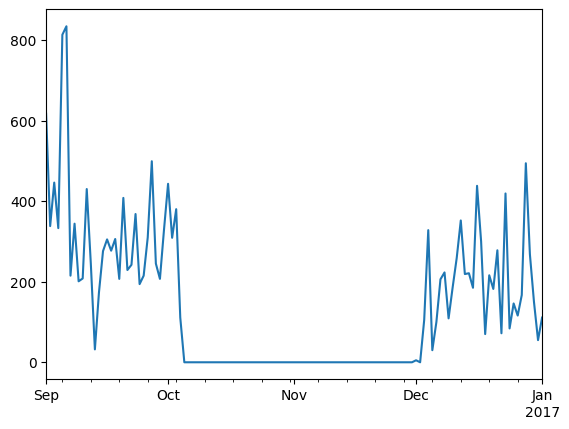

In [15]:
# Create a complete date range from the minimum to the maximum date
date_range = pd.date_range(start='2016-09-01', end='2017-01-01')
pivot_table = data.pivot_table(index='SKU', columns='DATE', values='QUANTITY_SOLD', fill_value=0)
pivot_table = pivot_table.reindex(columns=date_range, fill_value=0)
pivot_table.sum().plot()

it seems that the store closed for two months at the end of 2016

For a primar cleaning and better understanding of the dataset, we are going to restrict ourself to data after 2017.
We are going to keep as well SKUs that have more than 30 appearances over the last 2 years which seems the most relevant for our case study

In [16]:

# Consider data from 2017 onwards
data = data[data.YEAR >= 2017]

yearly_appearances = data.groupby(['SKU', 'YEAR']).size().unstack(fill_value=0)
last_two_years_appearances = yearly_appearances[[2023, 2024]].sum(axis=1)
skus_to_keep = last_two_years_appearances[last_two_years_appearances >= 30].index
data = data[data['SKU'].isin(skus_to_keep)]

count    2612.000000
mean      379.119449
std       442.320505
min        18.000000
10%        39.000000
25%        70.000000
50%       203.000000
75%       519.250000
90%       972.700000
max      2603.000000
Name: SKU, dtype: float64


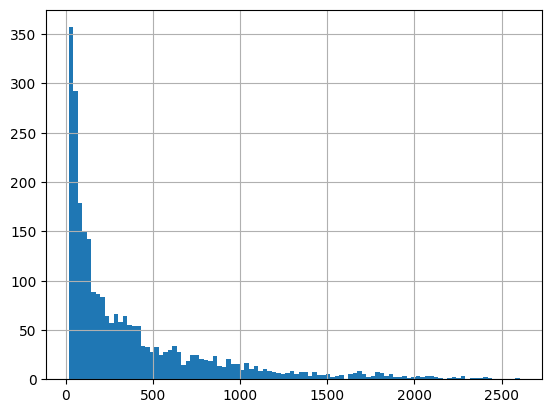

In [17]:
data.SKU.value_counts().hist(bins=100)
print(data.SKU.value_counts().describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))


### analysis of the quantitative variables

In [18]:
data[["QUANTITY_SOLD", "CURRENT_LEVEL"]].describe()

,QUANTITY_SOLD,CURRENT_LEVEL
count,990260.000000,990260.000000
mean,6.084004,3310.973051
std,26.449805,13808.980669
min,0.000000,1.000000
25%,1.000000,66.000000
50%,2.000000,252.000000
75%,5.000000,1571.000000
max,10040.000000,185549.000000


The current level seems to be a fixed variable for each SKU indicating the current existing level at the date of generation of the dataset at the store

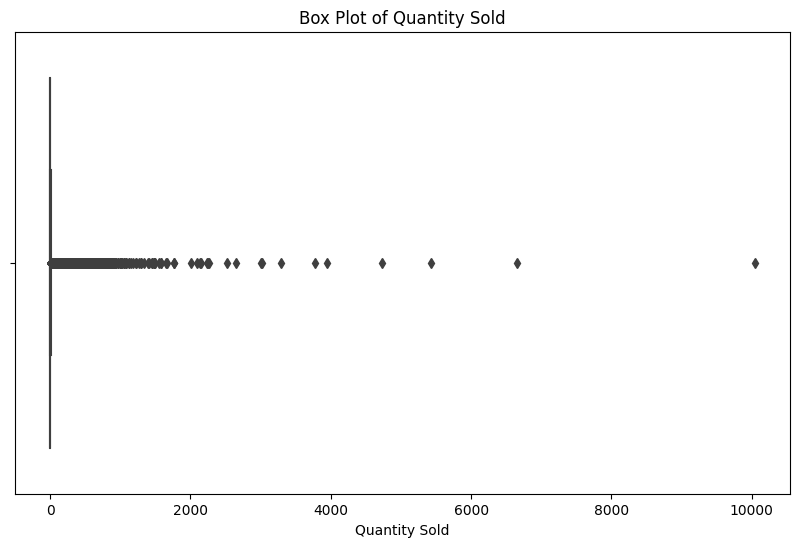

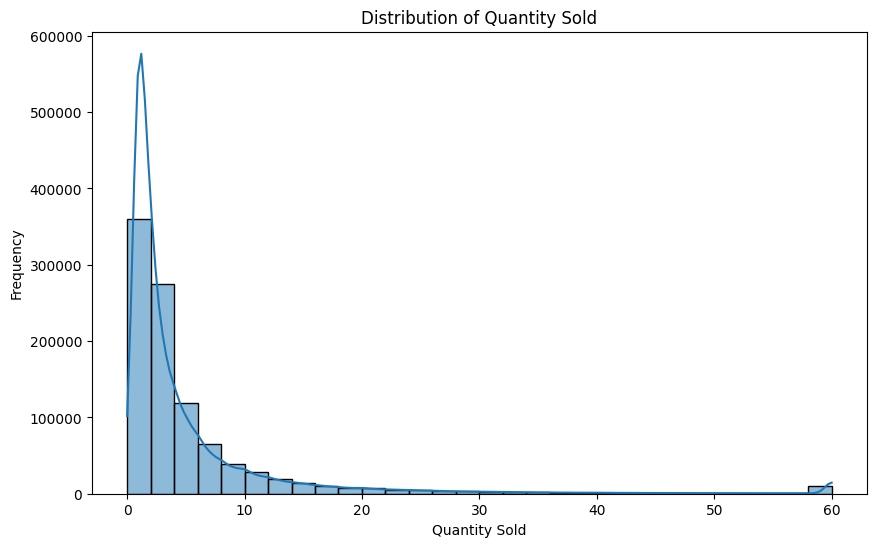

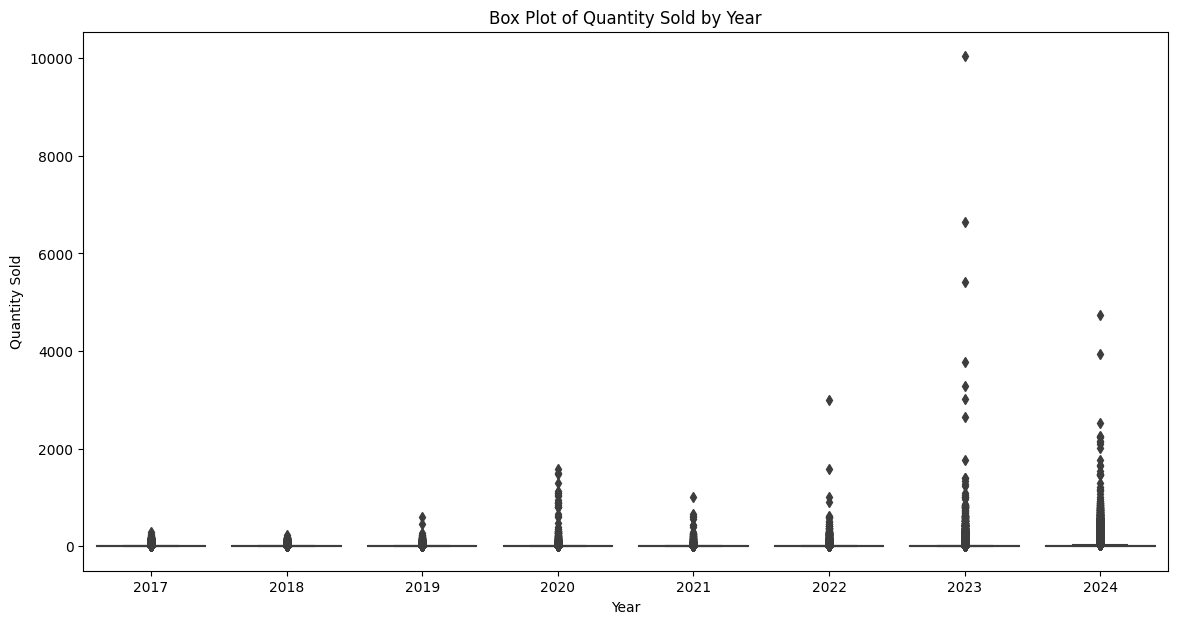

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['QUANTITY_SOLD'])
plt.title('Box Plot of Quantity Sold')
plt.xlabel('Quantity Sold')
plt.show()

threshold = data['QUANTITY_SOLD'].quantile(0.99)
data['QUANTITY_SOLD_CAPPED'] = data['QUANTITY_SOLD'].clip(upper=threshold)

# Plot the histogram of capped quantity sold
plt.figure(figsize=(10, 6))
sns.histplot(data['QUANTITY_SOLD_CAPPED'], bins=30, kde=True)
plt.title('Distribution of Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()

data['DATE'] = pd.to_datetime(data['DATE'])
data['year'] = data['DATE'].dt.year
data['month'] = data['DATE'].dt.month


# Box plot for quantity sold by year
plt.figure(figsize=(14, 7))
sns.boxplot(x='year', y='QUANTITY_SOLD', data=data)
plt.title('Box Plot of Quantity Sold by Year')
plt.xlabel('Year')
plt.ylabel('Quantity Sold')
plt.show()

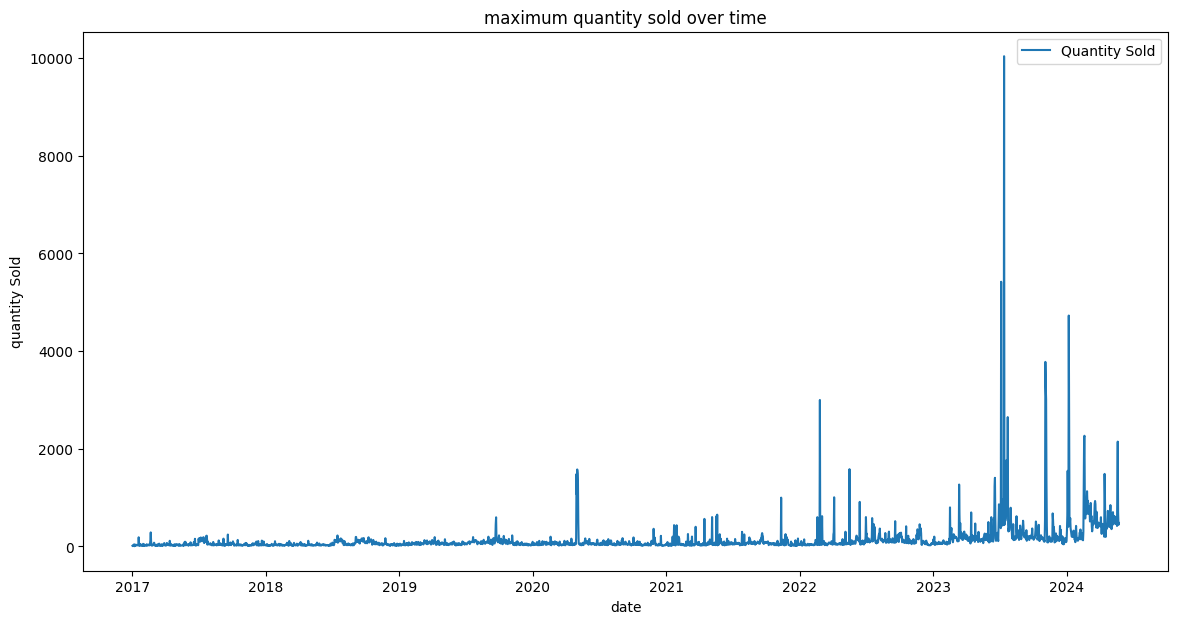

In [20]:

daily_quantity_sold = data.groupby('DATE')['QUANTITY_SOLD'].max().reset_index()

# maximum quantity sold over time
plt.figure(figsize=(14, 7))
plt.plot(daily_quantity_sold['DATE'], daily_quantity_sold['QUANTITY_SOLD'], label='Quantity Sold')
plt.title('maximum quantity sold over time')
plt.xlabel('date')
plt.ylabel('quantity Sold')
plt.legend()
plt.show()

Even though high quantities seem as individual scarce event , they are becoming more and more frequent and thus we are not going to filter these high quantities

# Temporal analysis

## random SKU temporal analysis

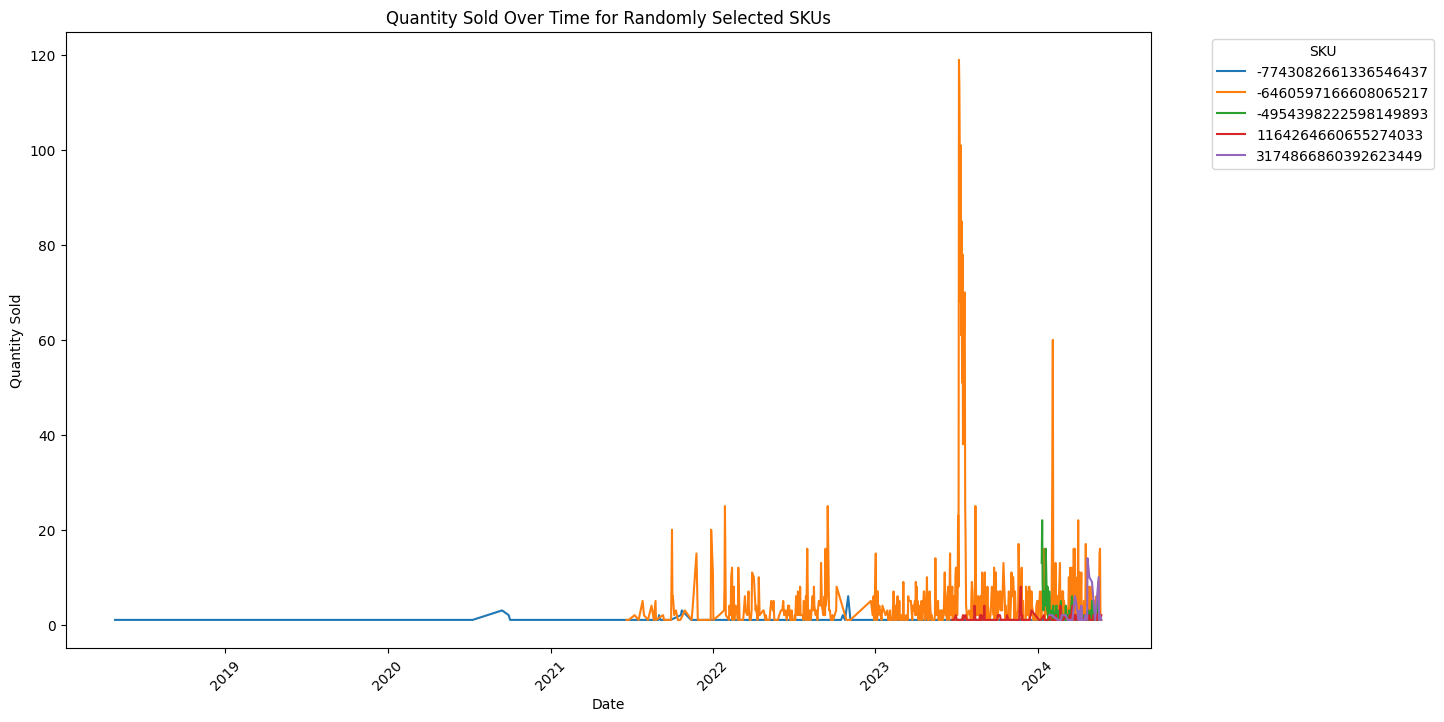

In [21]:
# Randomly select 5 SKUs
random_skus = np.random.choice(data['SKU'].unique(), size=5, replace=False)
random_skus_data = data[data['SKU'].isin(random_skus)]

# Group by SKU and Year and calculate mean quantity sold

plt.figure(figsize=(14, 8))
sns.lineplot(data=random_skus_data, x='DATE', y='QUANTITY_SOLD', hue='SKU', palette='tab10')
plt.title('Quantity Sold Over Time for Randomly Selected SKUs')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend(title='SKU', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.show()

We can see a lot of scarcity in the data for each SKU, we can also see that not all the SKU sales cover the globality of the range of the studied period. We have already seen the number of unique SKUs per month but to study further the scarcity let's see it by date 

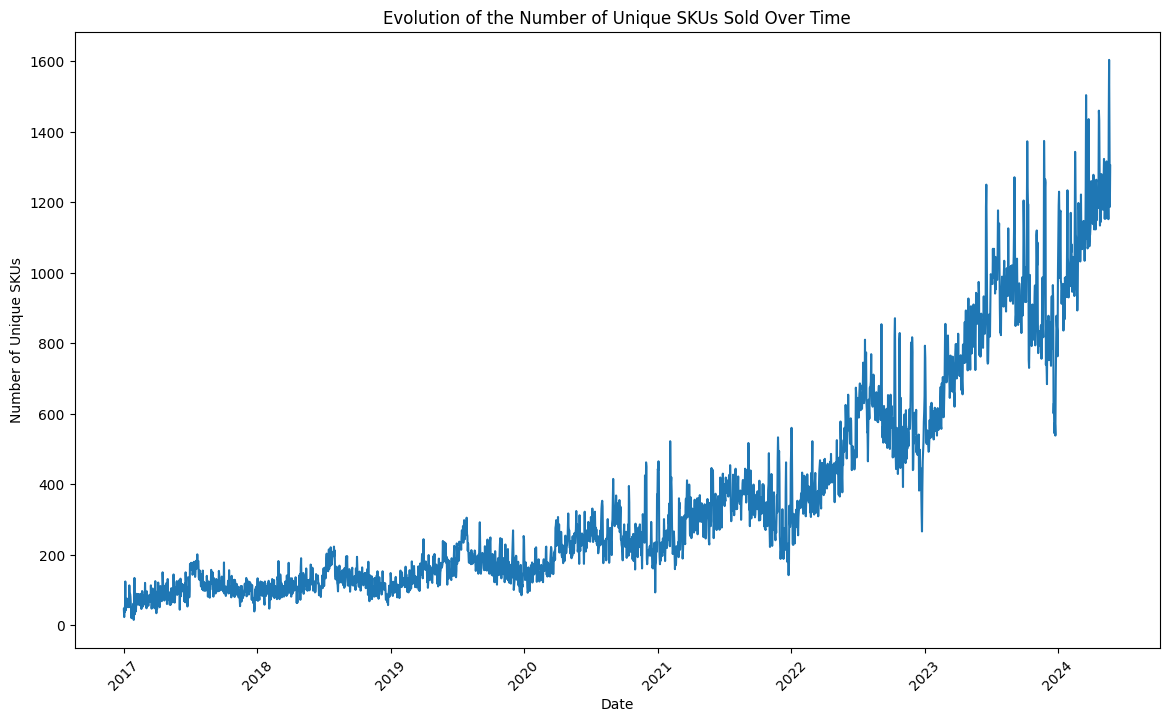

In [22]:
skus_per_date = data.groupby('DATE')['SKU'].nunique().reset_index()
skus_per_date.columns = ['DATE', 'UNIQUE_SKUS']

# Plot the number of unique SKUs over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=skus_per_date, x='DATE', y='UNIQUE_SKUS')
plt.title('Evolution of the Number of Unique SKUs Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Unique SKUs')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

Indeed, we can see that the number of SKUs sold has an increasing trend overall, to get a better idea about this business, let's try to study the global quantity sold overall

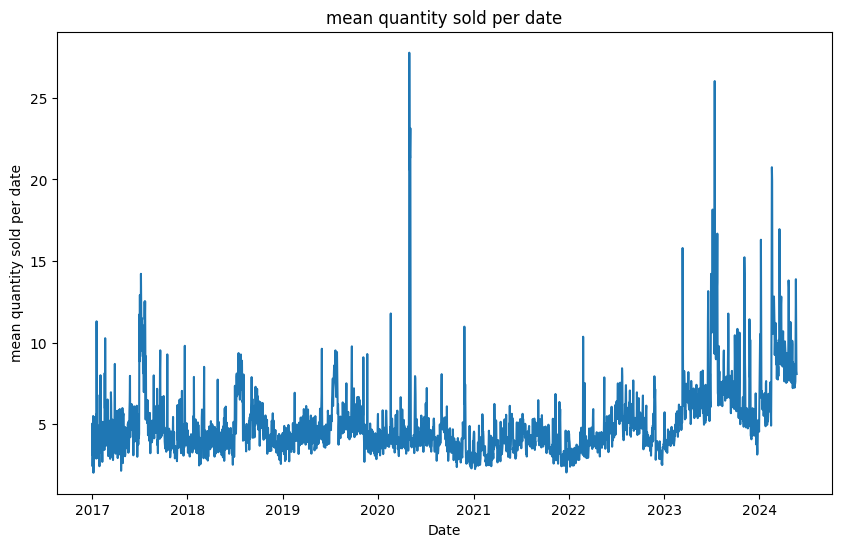

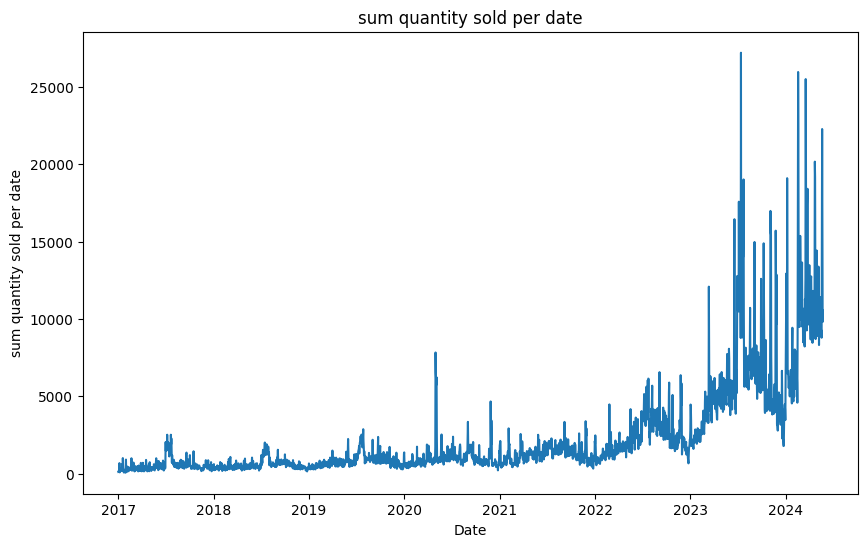

In [23]:
mean_quantity_per_date = data.groupby('DATE')['QUANTITY_SOLD'].mean().reset_index()
sum_quantity_per_date = data.groupby('DATE')['QUANTITY_SOLD'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_quantity_per_date, x='DATE', y='QUANTITY_SOLD')
plt.title('mean quantity sold per date')
plt.xlabel('Date')
plt.ylabel('mean quantity sold per date')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_quantity_per_date, x='DATE', y='QUANTITY_SOLD')
plt.title('sum quantity sold per date')
plt.xlabel('Date')
plt.ylabel('sum quantity sold per date')
plt.show()

We can see that total quantity sold per date has grown over the years but mainly because of the number of SKUs sold by day has grown significantly but the mean quantity sold per number of SKUs has less significant increasing trend. let's focus further on the temporal analysis of the mean and the sum to understand further the business 

## temporal analysis of sum of quantity sold

### daily

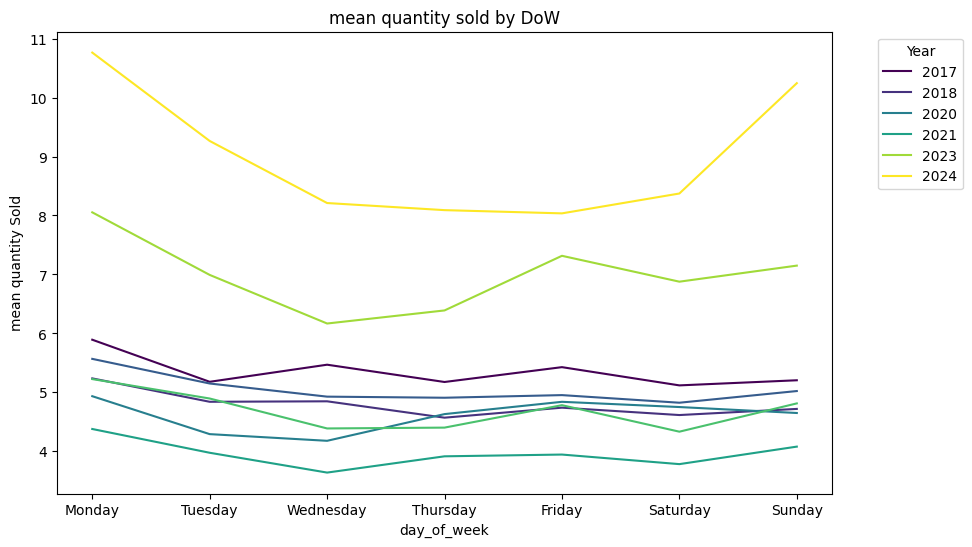

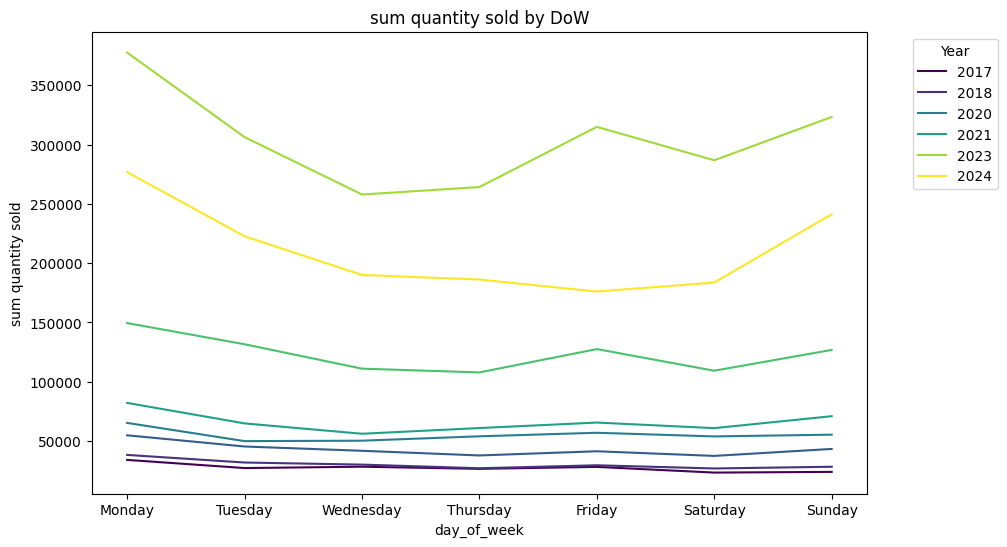

In [24]:
data['day_of_week'] = data['DATE'].dt.day_name()
data['year'] = data['DATE'].dt.year

mean_quantity_per_day_week = data.groupby(['year', 'day_of_week'])['QUANTITY_SOLD'].mean().reset_index()
sum_quantity_per_day_week = data.groupby(['year', 'day_of_week'])['QUANTITY_SOLD'].sum().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_quantity_per_day_week['day_of_week'] = pd.Categorical(mean_quantity_per_day_week['day_of_week'], categories=days_order, ordered=True)
sum_quantity_per_day_week['day_of_week'] = pd.Categorical(sum_quantity_per_day_week['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_quantity_per_day_week, x='day_of_week', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('mean quantity sold by DoW')
plt.xlabel('day_of_week')
plt.ylabel('mean quantity Sold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_quantity_per_day_week, x='day_of_week', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('sum quantity sold by DoW')
plt.xlabel('day_of_week')
plt.ylabel('sum quantity sold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see that the shop works on weekends as well, the sales start strong in the beginning of the week and rise slightly on the weekends

### Monthly

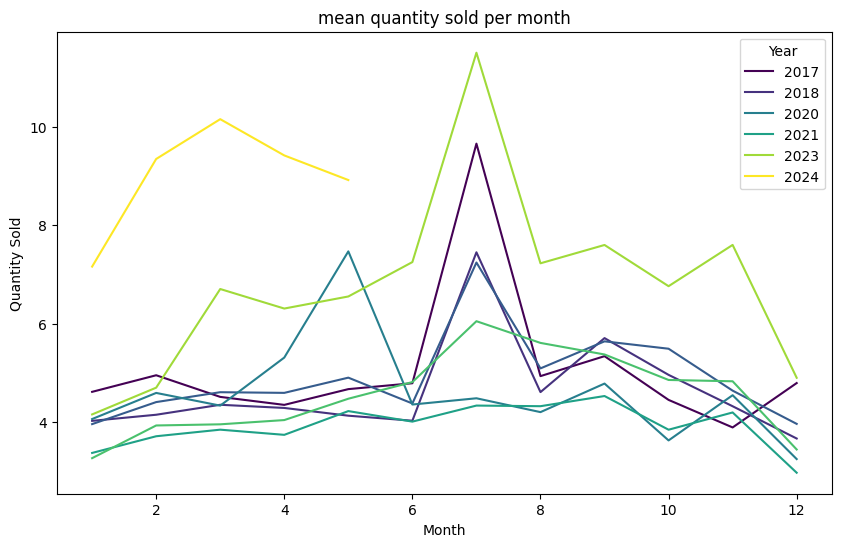

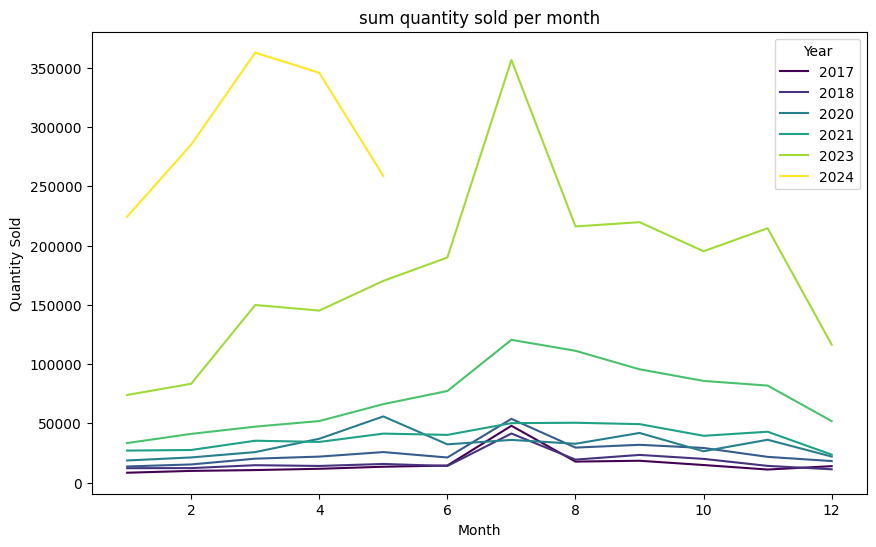

In [25]:
mean_quantity_per_month_year = data.groupby(['year', 'month'])['QUANTITY_SOLD'].mean().reset_index()
sum_quantity_per_month_year = data.groupby(['year', 'month'])['QUANTITY_SOLD'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_quantity_per_month_year, x='month', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('mean quantity sold per month')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend(title='Year')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_quantity_per_month_year, x='month', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('sum quantity sold per month')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend(title='Year')
plt.show()

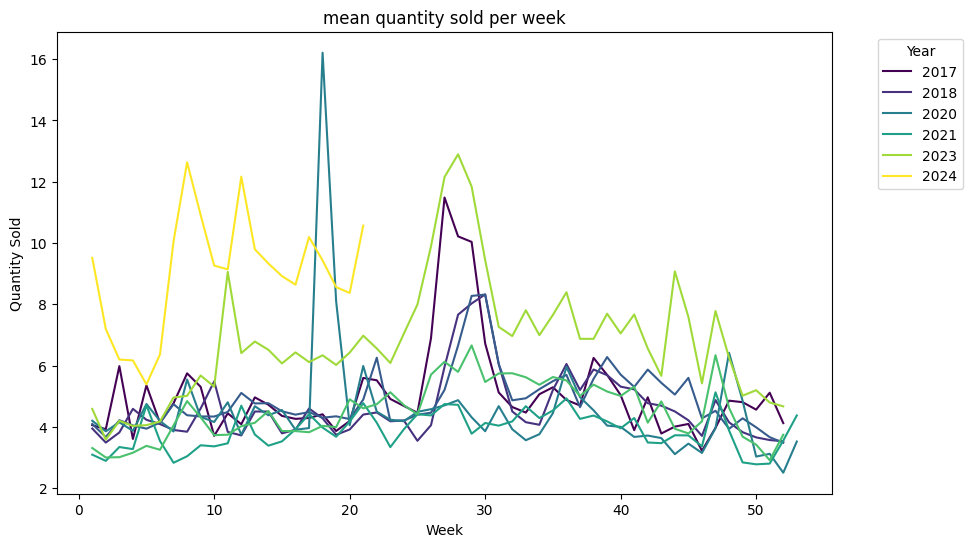

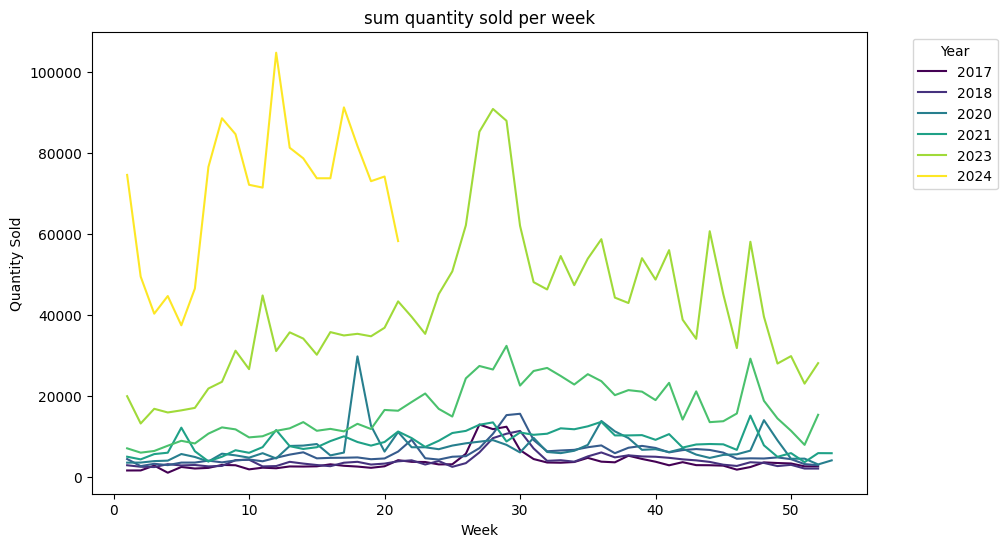

In [26]:
# Add a column for the week of the year
data['week_of_year'] = data['DATE'].dt.isocalendar().week

# Calculate mean and sum quantities sold by week of the year and year
mean_quantity_per_week_year = data.groupby(['year', 'week_of_year'])['QUANTITY_SOLD'].mean().reset_index()
sum_quantity_per_week_year = data.groupby(['year', 'week_of_year'])['QUANTITY_SOLD'].sum().reset_index()

# Plot mean quantity sold by week of the year
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_quantity_per_week_year, x='week_of_year', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('mean quantity sold per week')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot sum quantity sold by week of the year
plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_quantity_per_week_year, x='week_of_year', y='QUANTITY_SOLD', hue='year', palette='viridis')
plt.title('sum quantity sold per week')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

business rises during summer season and  in november (black friday ? christmas shopping) declines after the winter holidays

## seasonal decomposition

<AxesSubplot:xlabel='DATE'>

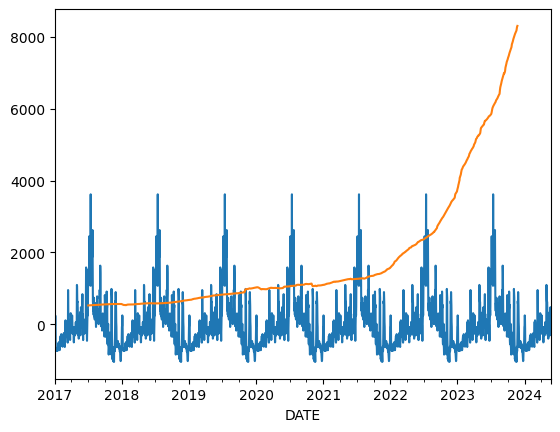

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily_sales = data.groupby('DATE')['QUANTITY_SOLD'].sum()

decomposition = seasonal_decompose(daily_sales, model='additive', period=365)
decomposition._seasonal.plot()
decomposition._trend.plot()

<AxesSubplot:xlabel='DATE'>

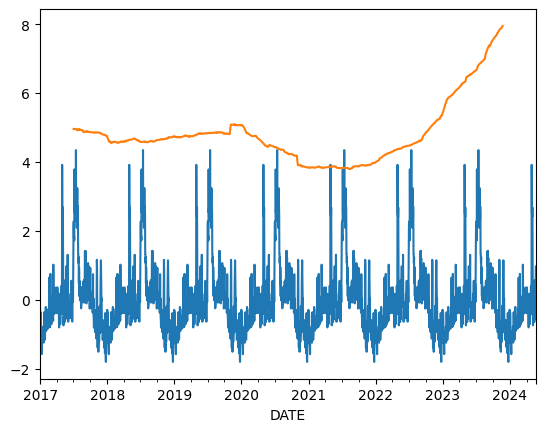

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily_sales = data.groupby('DATE')['QUANTITY_SOLD'].mean()

decomposition = seasonal_decompose(daily_sales, model='additive', period=365)
decomposition._seasonal.plot()
decomposition._trend.plot()